# Instruções

1- Responda as perguntas listadas no README.md; <br>
2- Faça as análises que julgar necessárias e deixe os resultados de suas análises plotadas no notebook.

# Pacotes Adicionais

```cmd
> pip install seaborn

```

<br>

# Análise Exploratória

In [1]:
import pandas as pd
import geopandas as gpd

## Qual a área total desmatada em hectares no estado de Minas Gerais em cada um dos meses de agosto e setembro de 2022?

In [215]:
gdf_desmat = gpd.read_file('./dados/focos-desmatamento-mg.geojson')

In [216]:
gdf_desmat.head(3)

,id,Instância,Data Inicial,Data Final,Cena,Score,Bioma,NuFis,Cia PM,geometry
0,6726,9696,26/07/2022,05/08/2022,22KFC,0.9,Cerrado,Triângulo Mineiro,5,"POLYGON ((65610.256 7779397.013, 65659.326 777..."
1,6727,9700,21/07/2022,26/07/2022,22KFD,0.9,Cerrado,Triângulo Mineiro,5,"POLYGON ((31696.271 7842130.438, 31989.678 784..."
2,6728,9701,21/07/2022,26/07/2022,22KFD,0.9,Cerrado,Triângulo Mineiro,5,"POLYGON ((50597.259 7823297.562, 50665.831 782..."


In [217]:
# Calculando a área com base na coluna 'geometry'
gdf_desmat['Area Desmatada'] = gdf_desmat.geometry.area 

Para extrair a informação do mês serão utilizadas as colunas `Data Inicial` e `Data Final`. A totalização da area desmatada por mês irá considerar apenas os desmatamentos que iniciaram e finalizaram dentro de determinado mês, pois neste caso é possível afirmar sobre a área desmatada.

Uma alternativa à premissa acima seria considerar uma parcela da área desmatada total proporcional aos dias de agosto e/ou setembro compreendidos entre a `Data Inicial` e `Data Final`. Contudo, essa é uma suposição muito forte, pois ela considera que o desmate foi realizado de forma linear durante todo o período o que não é algo factível ou que pode ser comprovado.

In [218]:
# Convertendo as colunas de datas para formato datetime (fins de manipulação de datas)
gdf_desmat['Data Inicial'] = pd.to_datetime(gdf_desmat['Data Inicial'], format='%d/%m/%Y')
gdf_desmat['Data Final'] = pd.to_datetime(gdf_desmat['Data Final'], format='%d/%m/%Y')

In [219]:
mes_inicio = gdf_desmat['Data Inicial'].dt.month
mes_fim = gdf_desmat['Data Final'].dt.month

Filtrando o conjunto de dados para o mês 8 (Agosto) e 9 (Setembro)

In [220]:
gdf_agosto = gdf_desmat.loc[(mes_inicio == 8) & (mes_fim == 8)]
area_desmat_agosto = gdf_agosto['Area Desmatada'].sum() / 1e4  # [m²] --> [hm²]

gdf_setembro = gdf_desmat.loc[(mes_inicio == 9) & (mes_fim == 9)]
area_desmat_setembro = gdf_setembro['Area Desmatada'].sum() / 1e4  # [m²] --> [hm²]

In [221]:
print(f'Area Total de Desmate em Agosto: {area_desmat_agosto:.2f} hectares')
print(f'Area Total de Desmate em Setembro: {area_desmat_setembro:.2f} hectares')

Area Total de Desmate em Agosto: 100.14 hectares
Area Total de Desmate em Setembro: 23466.84 hectares


<br>

## Qual a área total desmatada em km² no estado de Minas Gerais em todo o período fornecido (ago/set de 2022) por bioma?

In [222]:
gdf_desmat.groupby('Bioma')['Area Desmatada'].sum() / 1e6

Bioma
Caatinga           58.671766
Cerrado           234.941821
Mata Atlântica    118.017844
Name: Area Desmatada, dtype: float64

**Area total desmatada por Bioma:**
- Caatinga: 58.67 km² <br>
- Cerrado: 234.94 km² <br>
- Mata Atlântica: 118.02 km² <br>

<br>

## Qual a área total desmatada em km² no estado de Minas Gerais em cada um dos meses de agosto e setembro de 2022, por município

Originalmente o conjunto de dados `focos-desmatamento-mg.geojson` não possui informação referente aos municípios. Entretando, este conjunto possui informações referentes aos polígonos das áreas desmatadas. Portanto, pode-se cruzar os dados da area desmatada com as areas dos municipios no conjunto de dados `municipios-mg.geojson`. Quando houver interseção entre a área desmatada e o município sabe-se que a região de desmate pertence ao município em questão.

In [223]:
gdf_municipios_mg = gpd.read_file('./dados/municipios-mg.geojson')

### Funções

In [224]:
def find_county(area_desmat, gdf_municipios):
    """Encontra o municipio referente à area desmatada.
    Args:
        area_desmat (shapely.geometry.polygon.Polygon): Perímetro da área desmatada.
        gdf_municipios (gpd.GeoDataFrame): Conjunto de dados contendo informações dos municípios.
    Returns:
        (str) Nome do município.
    """
    mask_municipio = gdf_municipios.geometry.map(
        lambda area_municipio: area_desmat.intersects(area_municipio))
    
    filtered_municipios = gdf_municipios.loc[mask_municipio]
    
    if len(filtered_municipios) == 0:
        return 'No Match'
    elif len(filtered_municipios) == 1:
        return filtered_municipios['name'].item()
    else:  
        return ';'.join(filtered_municipios['name'].tolist())

In [225]:
def pretty_print_county_info(county_info):
    """Imprime na tela a area desmatada de acordo com cada municipio em formato tabular
    
    Args:
        county_info (pd.Series): Série contendo o município como índice e a área desmatada.
    
    Returns:
        (None): Função de exibição. Nada é retornado.
    """
    print(f"{''.join(['-']*83)}")
    print("|{:^45}|".format('Município'), end='')
    print("{:^35}|".format('Area Desmatada [km²]'))
    print(f"{''.join(['-']*83)}")
    for county, area_desmat in county_info.items():
        print('|{:^45}|'.format(county), end='')
        print('{:^35.2f}|'.format(area_desmat))
        print(f"{''.join(['-']*83)}")

Aplicando a função para encontrar o municipio ao conjunto de dados de desmatamento

In [226]:
gdf_desmat['Município'] = gdf_desmat.geometry.apply(
    lambda area_desmat: find_county(area_desmat, gdf_municipios_mg))

Um problema surge ao criar essa espécie de mapeamento. A área desmatada não necessariamente está contida em um único município e pode se alastrar além dos limites do município. Sendo assim, ao criar as estatísticas sobre as areas desmatadas poderemos interpretar de forma errônea o resultado por causa dessa ambiguidade.

In [227]:
# Casos em que a área desmatada faz parte de mais de um município
multi_county_desmat = gdf_desmat.loc[gdf_desmat['Município'].str.contains(';')]
multi_county_desmat['Município']

10                                 Capinópolis;Ituiutaba
142                                      Bambuí;Medeiros
159             Santa Rita do Sapucaí;São José do Alegre
182                                   Bambuí;Doresópolis
196                           Augusto de Lima;Buenópolis
227                           Jequitaí;São João da Lagoa
253                                 Funilândia;Jequitibá
267                                      Corinto;Curvelo
279                           Felixlândia;Morro da Garça
286                                      Corinto;Curvelo
290                           Felixlândia;Morro da Garça
323             Alfredo Vasconcelos;Senhora dos Remédios
326     Desterro do Melo;Mercês;Santa Bárbara do Tugúrio
389                          Mesquita;Santana do Paraíso
394                              Caratinga;Vargem Alegre
403                    Santa Maria do Suaçuí;Virgolândia
522                          Capitão Enéas;Montes Claros
548                            

<br>

Para resolver esse problema iremos dividir as areas desmatadas de acordo com sua interseção com cada município.

In [228]:
def split_deforest_area_per_county(gdf_desmat, gdf_municipios):
    expanded_samples = []
    for i, gseries_desmat in gdf_desmat.iterrows():
        if ';' in gseries_desmat['Município']:
            municipios = gseries_desmat['Município'].split(';')

            filtered_municipios = gdf_municipios.loc[gdf_municipios['name'].isin(municipios)]

            intersection_areas = filtered_municipios.geometry.map(
                lambda area_municipio: area_municipio.intersection(gseries_desmat.geometry))

            new_samples = []
            for i, area in enumerate(intersection_areas.values):
                new_sample = gseries_desmat.copy()
                new_sample.geometry = area
                new_sample['Município'] = municipios[i]
                new_samples.append(new_sample)
            expanded_samples.extend(new_samples)
        else:
            expanded_samples.append(gseries_desmat)
    return gpd.GeoDataFrame(expanded_samples)

In [229]:
gdf_desmat = split_deforest_area_per_county(gdf_desmat, gdf_municipios_mg)

In [230]:
gdf_desmat.reset_index(inplace=True, drop=True)

In [234]:
# Filtrando novamente o conjunto de dados para considerar as amostras expandidas 
# com a area desmatada por municipio

mes_inicio = gdf_desmat['Data Inicial'].dt.month
mes_fim = gdf_desmat['Data Final'].dt.month

gdf_agosto = gdf_desmat.loc[(mes_inicio == 8) & (mes_fim == 8)]
gdf_setembro = gdf_desmat.loc[(mes_inicio == 9) & (mes_fim == 9)]

### Area total desmatada em km² no mês de Agosto, por município

In [235]:
gdf_desmat_agosto_per_county = gdf_agosto.groupby('Município')['Area Desmatada'].sum() / 1e6

In [236]:
pretty_print_county_info(gdf_desmat_agosto_per_county)

-----------------------------------------------------------------------------------
|                  Município                  |       Area Desmatada [km²]        |
-----------------------------------------------------------------------------------
|                   Frutal                    |               1.00                |
-----------------------------------------------------------------------------------


### Area total desmatada em km² no mês de Setembro, por município

In [237]:
gdf_desmat_setembro_per_county = gdf_setembro.groupby('Município')['Area Desmatada'].sum() / 1e6

In [238]:
pretty_print_county_info(gdf_desmat_setembro_per_county)

-----------------------------------------------------------------------------------
|                  Município                  |       Area Desmatada [km²]        |
-----------------------------------------------------------------------------------
|             Abadia dos Dourados             |               0.14                |
-----------------------------------------------------------------------------------
|                  Andradas                   |               0.03                |
-----------------------------------------------------------------------------------
|                  Araguari                   |               1.54                |
-----------------------------------------------------------------------------------
|                   Araporã                   |               3.31                |
-----------------------------------------------------------------------------------
|                   Arapuá                    |               0.08          

<br>

# Correlação entre os dados populacionais e áreas desmatadas

In [272]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Dados de Desmatamento

O data set de desmatamento foi retirado do IBGE e exportado no formato CSV. <br>
Link: https://www.ibge.gov.br/cidades-e-estados/mg

In [243]:
df_pop = pd.read_csv('./dados/populacao-pib-municipios-mg.csv')

In [244]:
df_pop.columns.tolist()

['Município',
 'Código',
 'Gentílico',
 'Prefeito [2021]',
 'Área Territorial - km² [2022]',
 'População residente - pessoas [2022]',
 'Densidade demográfica - hab/km² [2022]',
 'Escolarização (6 a 14 anos) - % [2010]',
 'IDHM (Índice de desenvolvimento humano municipal) [2010]',
 'Mortalidade infantil - óbitos por mil nascidos vivos [2020]',
 'Receitas realizadas - R$ (×1000) [2017]',
 'Despesas empenhadas - R$ (×1000) [2017]',
 'PIB per capita - R$ [2021]']

<br>

Para reduzir a poluição visual das colunas e facilitar a manipulação dos dados as colunas serão renomeadas e somente as mais pertinentes para a análise serão mantidas

In [245]:
df_pop.columns = df_pop.columns.str.replace(r'\s(\(.*|\[.*|-.*)', '', regex=True)

In [246]:
df_pop.head(2)

,Município,Código,Gentílico,Prefeito,Área Territorial,População residente,Densidade demográfica,Escolarização,IDHM,Mortalidade infantil,Receitas realizadas,Despesas empenhadas,PIB per capita
0,Abadia dos Dourados,3100104.0,abadiense,WANDERLEI LEMES SANTOS,880.461,6272.0,7.12,98.3,0.689,16.39,21894.89576,18793.52389,25174.26
1,Abaeté,3100203.0,abaetense,IVANIR DELADIER DA COSTA,1817.067,22675.0,12.48,99.8,0.698,24.10,45220.32463,40774.21946,23266.10


In [247]:
df_pop = df_pop.drop(columns=['Código', 'Gentílico', 'Prefeito'])

In [248]:
df_pop.head()

,Município,Área Territorial,População residente,Densidade demográfica,Escolarização,IDHM,Mortalidade infantil,Receitas realizadas,Despesas empenhadas,PIB per capita
0,Abadia dos Dourados,880.461,6272.0,7.12,98.3,0.689,16.39,21894.89576,18793.52389,25174.26
1,Abaeté,1817.067,22675.0,12.48,99.8,0.698,24.10,45220.32463,40774.21946,23266.10
2,Abre Campo,470.551,13927.0,29.60,97.4,0.654,NaN,32100.12090,29577.56666,19553.86
3,Acaiaca,101.886,3909.0,38.37,96.0,0.630,NaN,14072.55633,12445.28291,16247.06
4,Açucena,815.422,8943.0,10.97,96.7,0.610,10.64,19477.67359,19513.35699,17888.20


<br>

## Unindo os conjuntos de dados com base na coluna Município

Para realizar a análise de correlação as colunas dos dados populacionais serão unidas com o conjunto de dados de desmatamento (area desmatada)

In [249]:
gdf_desmat_municipio = gdf_desmat[['Area Desmatada', 'Município']]

In [250]:
# Somando as áreas desmatadas por município
gdf_desmat_municipio = gdf_desmat_municipio.groupby('Município').sum().reset_index()

In [251]:
# Transformando a área desmatada em [km²] para reduzir a escala da variável
gdf_desmat_municipio['Area Desmatada'] /= 1e6

In [252]:
df_pop_analysis = pd.merge(gdf_desmat_municipio, df_pop, on='Município', how='inner')

In [253]:
df_pop_analysis = df_pop_analysis.set_index('Município')

<br>

## Análise de Correlação

Para analisar a relação entre a área desmatada e os demais indicadores populacionais será calculado o coeficiente de Pearson entre elas a fim de compreender se existe alguma linearidade entre elas

In [254]:
df_pop_corr = df_pop_analysis.corr()

In [256]:
df_pop_corr

,Area Desmatada,Área Territorial,População residente,Densidade demográfica,Escolarização,IDHM,Mortalidade infantil,Receitas realizadas,Despesas empenhadas,PIB per capita
Area Desmatada,1.000000,0.541537,0.107231,-0.021956,-0.031465,0.164288,-0.174306,0.076587,0.068000,0.190044
Área Territorial,0.541537,1.000000,0.110246,-0.053897,-0.122680,0.083721,-0.208003,0.061017,0.051909,0.109908
População residente,0.107231,0.110246,1.000000,0.928952,0.022589,0.287941,-0.123036,0.987512,0.984227,0.065219
Densidade demográfica,-0.021956,-0.053897,0.928952,1.000000,0.021410,0.201697,-0.068028,0.965938,0.969709,0.034617
Escolarização,-0.031465,-0.122680,0.022589,0.021410,1.000000,0.307254,0.073901,0.018705,0.017126,0.092326
IDHM,0.164288,0.083721,0.287941,0.201697,0.307254,1.000000,-0.258009,0.244236,0.233149,0.335925
Mortalidade infantil,-0.174306,-0.208003,-0.123036,-0.068028,0.073901,-0.258009,1.000000,-0.090632,-0.085329,-0.067270
Receitas realizadas,0.076587,0.061017,0.987512,0.965938,0.018705,0.244236,-0.090632,1.000000,0.999672,0.068998
Despesas empenhadas,0.068000,0.051909,0.984227,0.969709,0.017126,0.233149,-0.085329,0.999672,1.000000,0.062267
PIB per capita,0.190044,0.109908,0.065219,0.034617,0.092326,0.335925,-0.067270,0.068998,0.062267,1.000000


<Axes: >

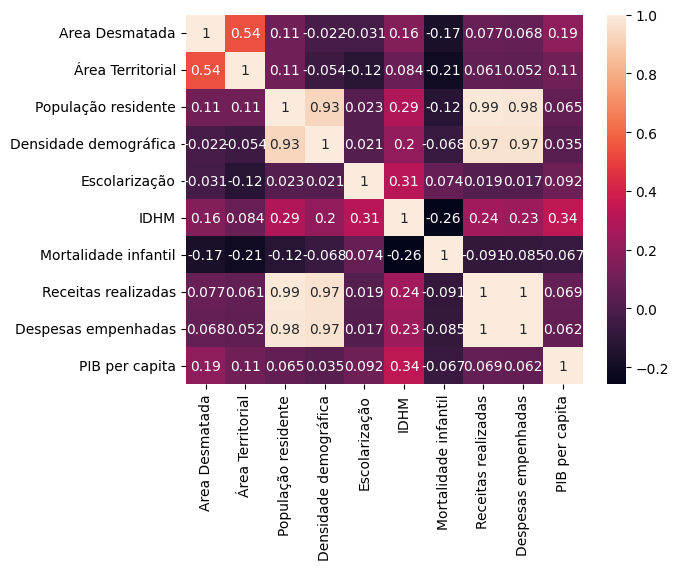

In [257]:
sns.heatmap(df_pop_corr, annot=True)

Pode-se perceber que o aspecto visual ficou bem carregado e existem muitos elementos que não fazem parte da análise. Se o objetivo é comparar a Area de Desmatamento com o restante das variaveis populacionais somente a primeira linha dessa matriz é suficiente. Os dados serão exibidos como um gráfico de barras com escala de cor ponderada pelo coeficiente de correlação.

In [258]:
df_pop_corr_imp_cols = df_pop_corr.iloc[[0], 1:].T

In [259]:
df_pop_corr_imp_cols

,Area Desmatada
Área Territorial,0.541537
População residente,0.107231
Densidade demográfica,-0.021956
Escolarização,-0.031465
IDHM,0.164288
Mortalidade infantil,-0.174306
Receitas realizadas,0.076587
Despesas empenhadas,0.068000
PIB per capita,0.190044


<Axes: >

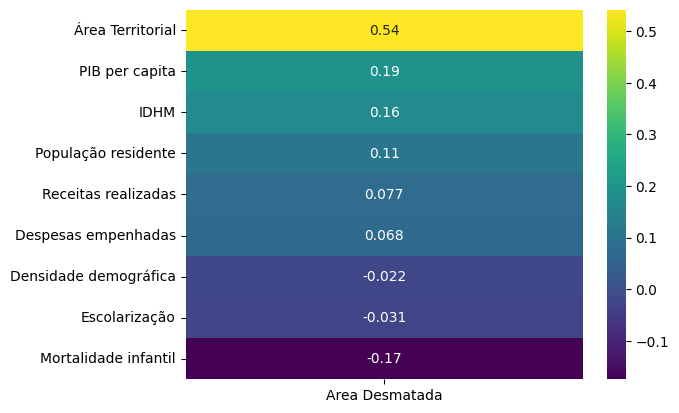

In [264]:
sns.heatmap(
    df_pop_corr_imp_cols.sort_values(by='Area Desmatada', ascending=False), 
    cmap='viridis', annot=True)

Observamos pelo mapa de cor acima que a área desmatada é proporcional à área territorial do município o que faz total sentido visto que municípios com extensões maiores podem ter áreas de desmate maiores também, proporcionalmente. Já as demais variáveis possuem uma correlação bem baixa como por exemplo o PIB, IDHM e a Mortalidade Infantil. Abaixo observamos a relação entre as três: 

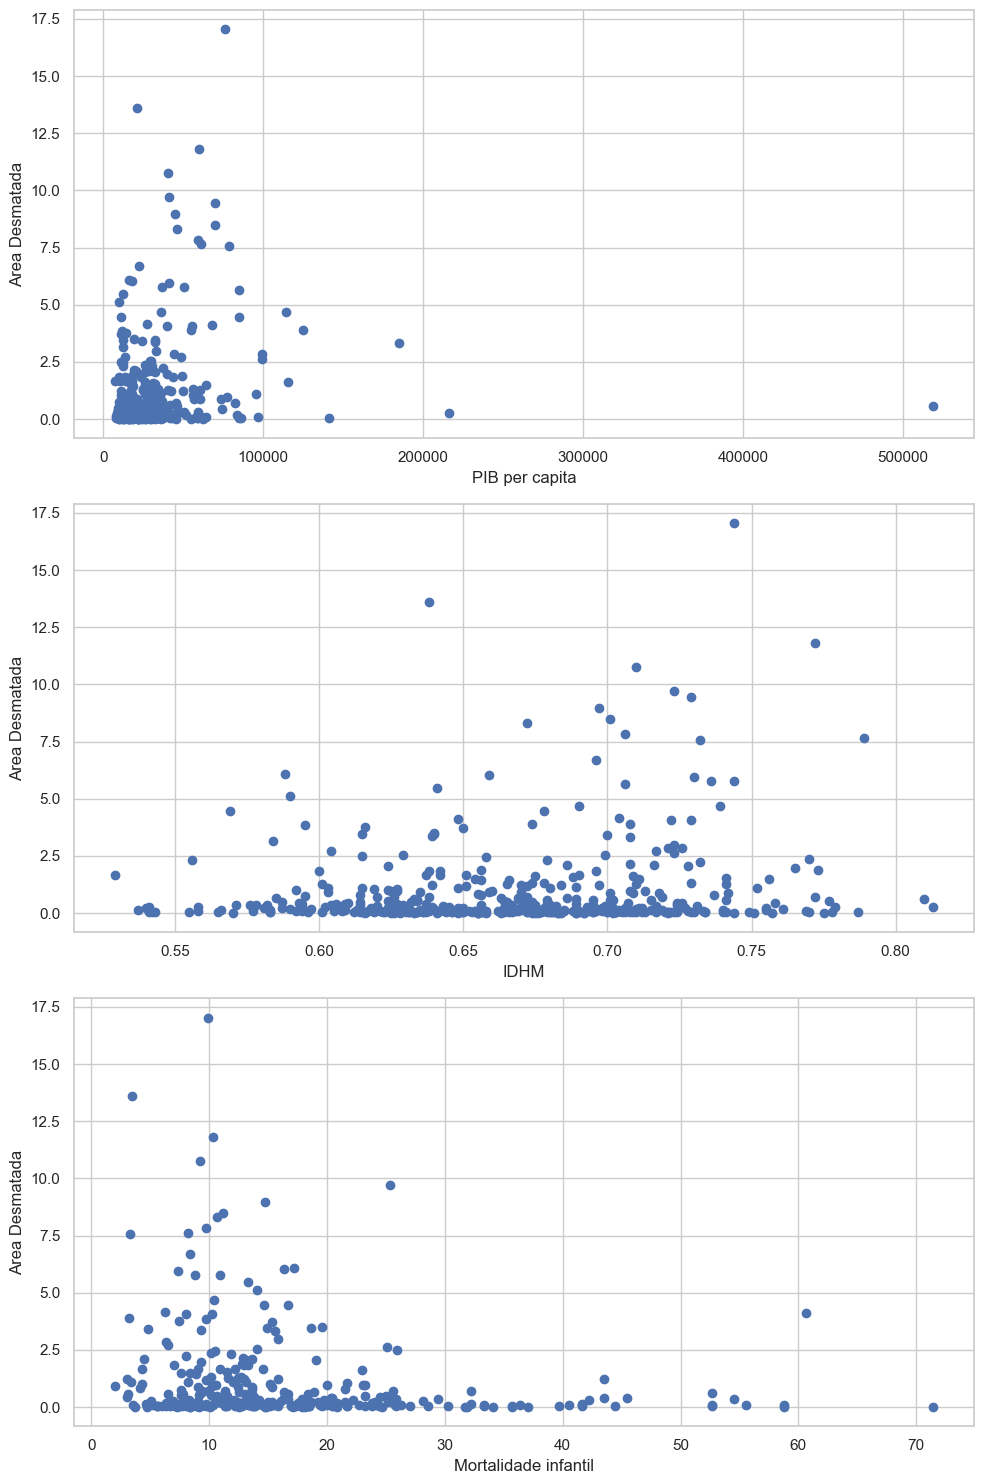

In [287]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,15))
cols = ['PIB per capita', 'IDHM', 'Mortalidade infantil']

for i, ax in enumerate(axes.flatten()):
    ax.scatter(df_pop_analysis[cols[i]], df_pop_analysis['Area Desmatada'])
    ax.set_xlabel(cols[i])
    ax.set_ylabel('Area Desmatada')
    
plt.subplots_adjust(hspace=0.2)
plt.tight_layout()

Como visto acima a correlação é muito baixa para que possam ser realizadas explorações adicionais
